In [1]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


This data contains the buying patterns of customers across various countries, therefore we need to choose a particular geography(Country) to get reliable segmentations. So lets take UK since this platform is originated out of the UK

In [3]:
uk_retl= retail_df[retail_df['Country']=='United Kingdom']
uk_retl.shape

(495478, 8)

To avoid obscurities we must remove the observations with cancelled orders

In [4]:
uk_retl= uk_retl[uk_retl['Quantity']>0]
uk_retl.shape

(486286, 8)

In [5]:
# remove rows where Cutomer ID is null
uk_retl.dropna(subset=['CustomerID'],how='all',inplace=True)
uk_retl.shape

(354345, 8)

We will have to choose a specific timeframe in terms of year since its a online shopping domain the preferences tend to be quite dynamic

In [6]:
uk_retl = uk_retl[uk_retl['InvoiceDate']>= "2010-12-09"]
uk_retl.shape

(342478, 8)

In [7]:
print('Summary')
print('No. of transactions',uk_retl['InvoiceNo'].nunique())
print('No. of customers',uk_retl['CustomerID'].nunique())
print('No. of products bought',uk_retl['StockCode'].nunique())

Summary
No. of transactions 16017
No. of customers 3863
No. of products bought 3611


### RFM Analysis

Recency,Frequency,Monetary is a customer segmntation technique employed by most of retailers both online and ones with outlets. Here the methodology is to analyze past data of buying patterns to discern which cluster should he or she be ideally placed in so as to assist in identifying those specific customers who are likely to respond to any promotions or special offers.

-RECENCY (R): Days since last purchase
-FREQUENCY (F): Total number of purchases
-MONETARY VALUE (M): Total money this customer spent.

#### Recency

In [8]:
# Last date in the dataset for reference
uk_retl['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


Create a feature which only contains only the date of the transaction

In [10]:
uk_retl['Date']=uk_retl['InvoiceDate'].dt.date
uk_retl.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


Group by customers and check the last date of purchase

In [11]:
recency_df=uk_retl.groupby(by='CustomerID',as_index=False)['Date'].max()
recency_df.columns=['CustomerID','last_dateof_purchase']
recency_df.head()

,CustomerID,last_dateof_purchase
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


Calculate recency

In [12]:
recency_df['recency']= recency_df['last_dateof_purchase'].apply(lambda x: (now-x).days)
recency_df.head()

,CustomerID,last_dateof_purchase,recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


We can see that customer 12346 did his last purchase long ago which was 325 days ago

In [13]:
recency_df.sort_values('recency',ascending=False)

,CustomerID,last_dateof_purchase,recency
2206,15945.0,2010-12-09,365
1074,14355.0,2010-12-09,365
2290,16065.0,2010-12-09,365
3647,17978.0,2010-12-09,365
3277,17456.0,2010-12-09,365
...,...,...,...
1135,14446.0,2011-12-09,0
3729,18102.0,2011-12-09,0
862,14051.0,2011-12-09,0
2187,15910.0,2011-12-09,0


In [14]:
recency_df.describe()

,CustomerID,recency
count,3863.000000,3863.000000
mean,15555.438519,87.537406
std,1575.752881,94.182509
min,12346.000000,0.000000
25%,14200.000000,17.000000
50%,15561.000000,49.000000
75%,16911.000000,134.000000
max,18287.000000,365.000000


The median gap betwen purchases is 49 days while the mean gap is 87 days, however th minimum gap is as less as not even a day but hours while the maximum recency at the farthest end is at 365 days

#### Frequency

In [15]:
retl_uk= uk_retl.copy()
retl_uk.drop_duplicates(subset=['InvoiceNo','CustomerID'],keep='first',inplace=True)
# calculate the frequency of purchases
freq_df= retl_uk.groupby(by='CustomerID',as_index=False)['InvoiceNo'].count()
freq_df.columns=['CustomerID','Frequency']
freq_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


In [16]:
freq_df.describe()

,CustomerID,Frequency
count,3863.000000,3863.000000
mean,15555.438519,4.146259
std,1575.752881,6.936763
min,12346.000000,1.000000
25%,14200.000000,1.000000
50%,15561.000000,2.000000
75%,16911.000000,5.000000
max,18287.000000,196.000000


The mean number of times a particular customer has shopped is 4 times, minimum is as low as 1 and maximum as high as 196 times

#### Monetary

In [17]:
retl_uk['total_cost']=retl_uk['Quantity']*retl_uk['UnitPrice']

In [18]:
monetary_df= retl_uk.groupby(by='CustomerID',as_index=False).agg({'total_cost':'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [19]:
monetary_df.describe()

,CustomerID,Monetary
count,3863.000000,3863.000000
mean,15555.438519,288.208496
std,1575.752881,3266.521065
min,12346.000000,0.000000
25%,14200.000000,17.400000
50%,15561.000000,45.000000
75%,16911.000000,121.600000
max,18287.000000,168471.250000


Median amount spent by customers is 45 pounds while mean is around 288.20 pounds which is due to outlier amounts as high as 168471 pounds

### Create RFM Table

In [20]:
rfm_df= recency_df.merge(freq_df,on='CustomerID')
rfm_df.head()

,CustomerID,last_dateof_purchase,recency,Frequency
0,12346.0,2011-01-18,325,1
1,12747.0,2011-12-07,2,10
2,12748.0,2011-12-09,0,196
3,12749.0,2011-12-06,3,5
4,12820.0,2011-12-06,3,4


In [21]:
rfm_df.drop('last_dateof_purchase',axis=1,inplace=True)

In [22]:
rfm_df= rfm_df.merge(monetary_df,on='CustomerID')
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

,recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


### Customer Segments with RFM model

After looking at the descriptive statistics of the data, I cannot help but wonder if pareto's principle applies here, since in exploratory analysis as well we saw that a few customers were purchasing equivalent to over what 1000 customers collectively purchase which relates to the principle that 80% of the revenue comes from 20% of the customers

#### Applying the 80-20 rule

In [23]:
# Find out 80% of the revenue
pareto_cut= rfm_df['Monetary'].sum()*0.8
print('80% of the revenue is {}'.format(round(pareto_cut,2)))

80% of the revenue is 890679.54


In [24]:
# rank the customers
customers_rank=rfm_df
customers_rank['Rank']=customers_rank['Monetary'].rank(ascending=0)
customers_rank.head()

,recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


#### Top customers

In [25]:
customers_rank.sort_values('Rank',ascending=True)

,recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


Get the top 20% of the customers

In [26]:
top_20_cut= 3863*0.2
top_20_cut

772.6

In [27]:
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

It is clear that these top 20% of our customers account for more than 80% of our revenue, therefore studying them shall be pivoted

### Applying the RFM score

In [28]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


In [29]:
quantiles.to_dict()

{'recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [31]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [33]:
rfm_segmentation=rfm_df
rfm_segmentation['R_quartile']=rfm_segmentation['recency'].apply(RScore,args=('recency',quantiles,))
rfm_segmentation['F_quartile']=rfm_segmentation['Frequency'].apply(FMScore,args=('Frequency',quantiles,))
rfm_segmentation['M_quartile']=rfm_segmentation['Monetary'].apply(FMScore,args=('Monetary',quantiles,))

Now we have to combine the RFM scores together

In [34]:
rfm_segmentation['RFM_score']=rfm_segmentation['R_quartile'].map(str)\
                              +rfm_segmentation['F_quartile'].map(str)\
                              +rfm_segmentation['M_quartile'].map(str)
rfm_segmentation.head()

,recency,Frequency,Monetary,Rank,R_quartile,F_quartile,M_quartile,RFM_score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

#### Top scorers

In [35]:
rfm_segmentation[rfm_segmentation['RFM_score']=='444'].sort_values('Monetary',ascending=False).head(10)

,recency,Frequency,Monetary,Rank,R_quartile,F_quartile,M_quartile,RFM_score
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


These are indeed our best customers and eligible to receive further more incentives to pledge their eternal loyalty

In [37]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_score']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


### Applying K-Means Clustering on RFM variables

In [38]:
rfm_data= rfm_df.drop(['R_quartile','F_quartile','M_quartile','RFM_score'],axis=1)
rfm_data.head()

,recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


Feature Correlations

In [40]:
rfm_data.drop('Rank',axis=1,inplace=True)
rfm_data.corr()

,recency,Frequency,Monetary
recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


<AxesSubplot:>

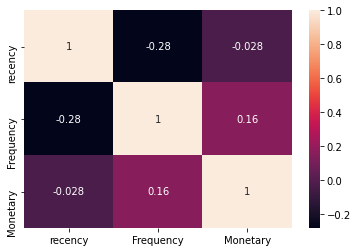

In [42]:
sns.heatmap(rfm_data.corr(),annot=True)

It was much anticipated that the correlation of Monetary and Frequency with Recency would be negative because for both monetary and frequency the values are higher the better on the other hand for Recency its lesser the better

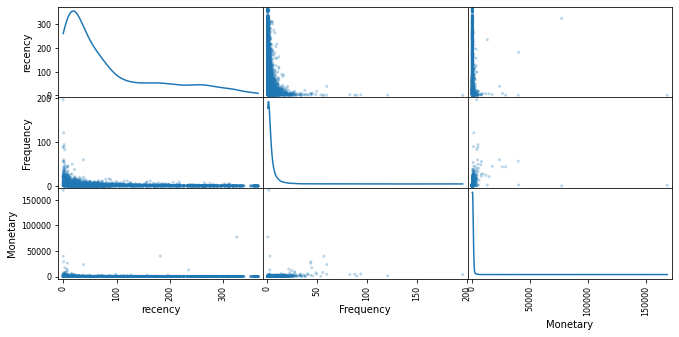

In [43]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

We can clearly see that Frequency and Monetary are characterized by a 'Power Law Distribution' whereas recency is characterized by a 'log normal distribution'.

Data Normalization

In [44]:
#log transformation
rfm_r_log = np.log(rfm_data['recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [45]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.490708,0.741937,2.302585
12748.0,8.226662,-2.302585,5.278115
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


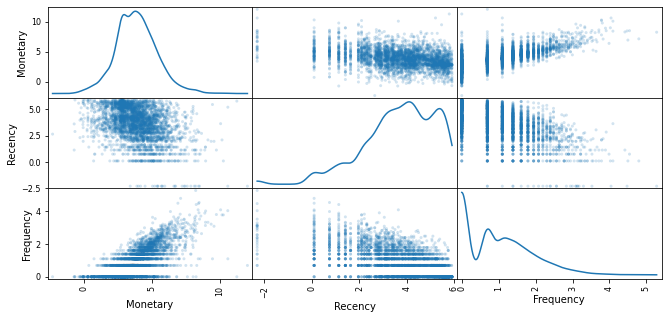

In [46]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');

Only the distribution of Monetary has improved

<AxesSubplot:>

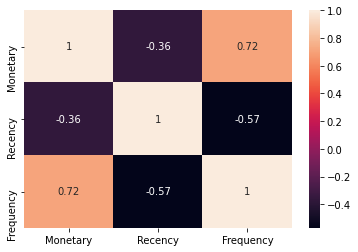

In [48]:
sns.heatmap(log_data.corr(),annot=True)

### K-Means Implementation

The common challenge with Kmeans is that we have to tell the algorithm how many clusters do we want, therefore we will iterate through different cluster numbers and pick the numbeer with the highest corresponding Silhoutte coefficient.
The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). 

In [50]:
X=log_data
for n_clusters in range(2,10):
    kmeans=KMeans(init='k-means++',n_clusters=n_clusters,n_init=100)
    kmeans.fit(X)
    clusters= kmeans.predict(X)
    silhoutte_avg= silhouette_score(X,clusters)
    print('For n_clusters=',n_clusters,'The Average Silhouette score is:',silhoutte_avg)

For n_clusters= 2 The Average Silhouette score is: 0.3894055410198746
For n_clusters= 3 The Average Silhouette score is: 0.3036071052941144
For n_clusters= 4 The Average Silhouette score is: 0.3097934824953256
For n_clusters= 5 The Average Silhouette score is: 0.29006058208354196
For n_clusters= 6 The Average Silhouette score is: 0.29534771240417823
For n_clusters= 7 The Average Silhouette score is: 0.29128648080510633
For n_clusters= 8 The Average Silhouette score is: 0.29159257564677044
For n_clusters= 9 The Average Silhouette score is: 0.2945294138026618


Best Silhouette score is obtained when no. of clusters are equal to 2

In [57]:
arr = log_data.to_numpy()

In [58]:
arr

array([[11.25394357,  5.78413283,  0.        ],
       [ 6.49070836,  0.74193734,  2.30258509],
       [ 8.22666173, -2.30258509,  5.27811466],
       ...,
       [ 3.64675453,  1.96009478,  0.69314718],
       [ 4.2024513 ,  1.13140211,  2.77258872],
       [ 4.38825718,  3.74004774,  1.09861229]])

In [59]:
n_clusters=2
kmeans=KMeans(init='k-means++',n_clusters=n_clusters,n_init=30)
kmeans.fit(arr)
cluster_customers=kmeans.predict(arr)
silhouette_avg=silhouette_score(arr,cluster_customers)
print('The silhouette score is {}'.format(silhouette_avg))

The silhouette score is 0.38930787566743014


### Visualize the clusters

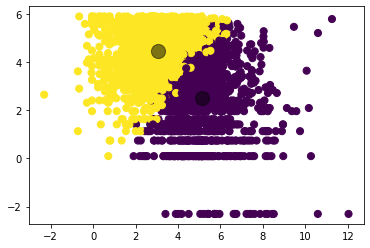

In [60]:
#create a scatter plot
plt.scatter(arr[:,0],arr[:,1], c=cluster_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [61]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(cluster_customers).value_counts(), columns = ['Number of Customers']).T

,1,0
Number of Customers,2335,1528


We got clearly seperated clusters however there is minute if any overlap. The limitations of kmeans is that it doesnt necessarily give the global best solution

### Gaussian Mixture Model implementation

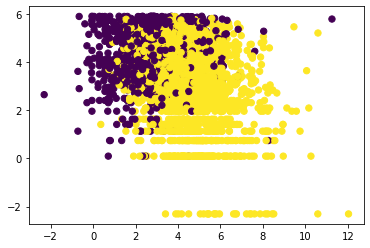

In [65]:
gm= GaussianMixture(n_components=2).fit(arr)
labels=gm.predict(arr)
plt.scatter(arr[:, 0], arr[:, 1], c=labels, s=40, cmap='viridis');

With Gaussian Mixture However we dont have clearly